In [92]:
import matplotlib.pyplot as plt
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig

# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [1]:
# Python code to simulate a toy seasonal surface temperature model using "radiative kernels"
# and to decompose the seasonal cycle into direct (forced) contributions and feedback contributions.
#
# The code is intentionally self-contained and uses simplified parameterizations so you can
# adapt it to real kernels and observed forcings later.
#
# Follows the user's request for Google-style docstrings and typed function signatures.
import numpy as np
import pandas as pd

from typing import Tuple, Dict

def day_of_year_to_solar_declination(day: int) -> float:
    """
    Compute approximate solar declination angle (radians) for a given day of year.

    Args:
        day (int): day of year (1-365)

    Returns:
        float: solar declination in radians
    """
    # approximate formula (Cooper, Ball, etc.): declination = 23.44° * sin(2π*(284+day)/365)
    return np.deg2rad(23.44) * np.sin(2 * np.pi * (day - 81) / 365.0)

def daily_top_of_atmosphere_insolation(latitude_deg: float, day: int, S0: float = 1361.0) -> float:
    """
    Compute daily-averaged TOA insolation (W/m2) for a given latitude and day using a simple
    analytic approximation (integrated over the day, neglecting eccentricity effects).

    Args:
        latitude_deg (float): latitude in degrees (positive north)
        day (int): day of year (1-365)
        S0 (float): solar constant (W/m2), default 1361

    Returns:
        float: daily mean TOA insolation (W/m2)
    """
    # This is a simple approximation: S0/pi * (daily average of cos(zenith) for sunlit fraction)
    lat = np.deg2rad(latitude_deg)
    decl = day_of_year_to_solar_declination(day)
    # hour angle of sunrise (radians)
    cos_omega0 = -np.tan(lat) * np.tan(decl)
    # clamp
    cos_omega0 = np.clip(cos_omega0, -1.0, 1.0)
    omega0 = np.arccos(cos_omega0)
    # daily average of insolation on a horizontal plane (see standard formula)
    # daily mean = (S0 / np.pi) * (omega0 * np.sin(lat) * np.sin(decl) + np.cos(lat) * np.cos(decl) * np.sin(omega0))
    daily_mean = (S0 / np.pi) * (omega0 * np.sin(lat) * np.sin(decl) + np.cos(lat) * np.cos(decl) * np.sin(omega0))
    return float(daily_mean)


def planck_surface_sensitivity(Tkelvin: float) -> float:
    """
    Compute the Planck (LW) sensitivity at the surface: dF/dT ≈ 4 * sigma * T^3 (W m^-2 K^-1).

    Args:
        Tkelvin (float): surface temperature in Kelvin

    Returns:
        float: dLW_net/dT (W m^-2 K^-1), negative sign for net cooling is applied externally
    """
    sigma = 5.670374419e-8
    return 4.0 * sigma * (Tkelvin ** 3)


def run_seasonal_model(
    latitude: float = 55.97,
    year_days: int = 365,
    C: float = 2.0e7,
    T0: float = 273.15 + 5.0,
    transmissivity_clear: float = 0.7,
    K_cloud_SW: float = -80.0,
    K_RH_LW: float = +2.0,
    k_turbulent: float = 5.0,
    RH_feedback_perK: float = -0.01,
    cloud_feedback_perK: float = -0.02,
    forced_RH_amplitude: float = 0.08,
    forced_cloud_amplitude: float = 0.15,
    dt_days: float = 1.0
) -> Dict[str, pd.DataFrame]:
    """
    Run a toy daily seasonal surface-temperature model and decompose the surface flux contributions
    into direct (forced) and feedback parts.

    The model is intentionally simple:
     - energy balance: C dT/dt = SW_to_surface + LW_net + SH_plus_LH (turbulent)
     - SW_to_surface = transmissivity_clear * TOA_insolation * (1 - cloud_fraction * cloud_sw_effect)
       but we handle clouds via kernel multiplication: SW contribution from insolation and clouds
     - LW_net ~ -Planck(T) + vapor/cloud greenhouse terms approximated as linear in RH and cloud fraction
     - SH+LH ~ - k_turbulent * (T - T_ref)  (a linearized loss to the atmosphere)
     - RH and cloud fraction each have a 'forced' seasonal cycle (sinusoidal) PLUS a linear feedback
       proportional to (T - T_ref): x(t) = x_forced(t) + f_x * (T - T_ref)

    Args:
        latitude (float): latitude (deg N) for insolation calc.
        year_days (int): number of days in model (default 365)
        C (float): effective heat capacity (J m^-2 K^-1)
        T0 (float): initial/reference surface temperature (K)
        transmissivity_clear (float): clear-sky surface transmissivity (0-1)
        K_cloud_SW (float): SW sensitivity to cloud fraction (W m^-2 per unit cloud fraction)
        K_RH_LW (float): LW sensitivity per unit relative humidity (W m^-2 per unit RH)
        k_turbulent (float): linear turbulent flux coefficient (W m^-2 K^-1)
        RH_feedback_perK (float): how much RH changes per K of surface warming (units RH per K)
        cloud_feedback_perK (float): how much cloud fraction changes per K of surface warming (unit cloud fraction per K)
        forced_RH_amplitude (float): amplitude of forced sinusoidal RH (peak-to-mean)
        forced_cloud_amplitude (float): amplitude of forced sinusoidal cloud fraction
        dt_days (float): time step in days (default 1)

    Returns:
        dict: dictionary of pandas DataFrames with keys:
          - 'state': Time series of T, RH_total, cloud_total
          - 'forcings': time series of forced (independent) components
          - 'contribs': instantaneous contributions to net surface energy balance from each term
          - 'decomp': decomposition into forced vs feedback contributions for each term (SW_insolation, SW_cloud, LW_RH, turbulent)
    """
    # time array
    days = np.arange(1, year_days + 1)
    n = len(days)
    dt = dt_days * 86400.0  # convert days to seconds for heat capacity equation

    # arrays to store
    T = np.zeros(n) + T0  # Kelvin
    RH = np.zeros(n)
    cloud = np.zeros(n)
    TOA = np.zeros(n)

    # For decomposition we track 'forced' component and 'feedback component' of RH and cloud
    RH_forced = np.zeros(n)
    cloud_forced = np.zeros(n)
    RH_feedback_component = np.zeros(n)
    cloud_feedback_component = np.zeros(n)

    # contributions
    SW_insolation_flux = np.zeros(n)
    SW_cloud_flux = np.zeros(n)
    LW_planck_flux = np.zeros(n)
    LW_RH_flux = np.zeros(n)
    turbulent_flux = np.zeros(n)
    net_flux = np.zeros(n)

    # forced seasonal cycles (sinusoidal) phases: assume peak insolation at day ~ 172 (June 21)
    # For RH and cloud we give a simple sinusoid with adjustable amplitude; these are the 'external' forced variations.
    phase_shift = -81  # aligns day 172 as peak for insolation in our declination func
    # Normalize amplitude so forced_RH_amplitude is roughly the amplitude around T0
    for i, day in enumerate(days):
        TOA[i] = daily_top_of_atmosphere_insolation(latitude, int(day))
        # forced components: choose simple sinusoids in phase with insolation for this demo
        RH_forced[i] = 0.5 + forced_RH_amplitude * np.sin(2 * np.pi * (day - 172) / 365.0)  # mean RH ~0.5
        cloud_forced[i] = 0.5 + forced_cloud_amplitude * np.sin(2 * np.pi * (day - 200) / 365.0)  # phase slightly shifted

    # reference T and values
    T_ref = T0
    RH_ref = np.mean(RH_forced)
    cloud_ref = np.mean(cloud_forced)

    # Run forward Euler integration day-by-day
    for i, day in enumerate(days):
        # compute feedback parts based on current T (note: use T[i] which is current day's T)
        RH_feedback_component[i] = RH_feedback_perK * (T[i] - T_ref)
        cloud_feedback_component[i] = cloud_feedback_perK * (T[i] - T_ref)
        RH[i] = RH_forced[i] + RH_feedback_component[i]
        cloud[i] = cloud_forced[i] + cloud_feedback_component[i]
        # clip physical bounds
        RH[i] = np.clip(RH[i], 0.01, 0.99)
        cloud[i] = np.clip(cloud[i], 0.0, 1.0)

        # compute surface SW contributions:
        # direct insolation -> surface via transmissivity (ignoring angular dependence within day here)
        SW_from_insolation = transmissivity_clear * TOA[i]
        # cloud contribution: kernel times cloud fraction anomaly from reference (kernel negative for more cloud -> less SW)
        SW_from_cloud = K_cloud_SW * (cloud[i] - cloud_ref)

        # LW contributions:
        # planck cooling (approx) dF = -Planck * (T - T_ref)
        planck_sens = planck_surface_sensitivity(T[i])
        LW_from_planck = -planck_sens * (T[i] - T_ref)
        # LW greenhouse effect from RH and cloud (simple linear sensitivities)
        LW_from_RH = K_RH_LW * (RH[i] - RH_ref)
        LW_from_cloud_LW = 15.0 * (cloud[i] - cloud_ref)  # additive LW greenhouse effect per cloud frac unit

        # turbulent flux (sensible+latent) parameterized as linear sink ~ -k_turbulent*(T-T_ref)
        turbulent = -k_turbulent * (T[i] - T_ref)

        # net flux into surface (W/m2)
        net = SW_from_insolation + SW_from_cloud + LW_from_planck + LW_from_RH + LW_from_cloud_LW + turbulent

        # store instantaneous contributions
        SW_insolation_flux[i] = SW_from_insolation - transmissivity_clear * np.mean(TOA)  # transmit anomaly relative to mean
        SW_cloud_flux[i] = SW_from_cloud
        LW_planck_flux[i] = LW_from_planck
        LW_RH_flux[i] = LW_from_RH
        turbulent_flux[i] = turbulent
        net_flux[i] = net

        # advance temperature to next day via forward Euler (T_{n+1} = T_n + (net/C)*dt)
        if i < n - 1:
            T[i + 1] = T[i] + (net / C) * dt

    # Build DataFrames
    df_state = pd.DataFrame({
        "day": days,
        "T": T,
        "RH_total": RH,
        "RH_forced": RH_forced,
        "RH_feedback": RH_feedback_component,
        "cloud_total": cloud,
        "cloud_forced": cloud_forced,
        "cloud_feedback": cloud_feedback_component,
        "TOA": TOA
    }).set_index("day")

    df_forcings = pd.DataFrame({
        "TOA": TOA,
        "SW_transmissivity_mean_TOA_anom": SW_insolation_flux + transmissivity_clear * np.mean(TOA)  # also store raw
    }, index=days)

    df_contribs = pd.DataFrame({
        "SW_insolation": SW_insolation_flux,
        "SW_cloud": SW_cloud_flux,
        "LW_planck": LW_planck_flux,
        "LW_RH": LW_RH_flux,
        "LW_cloud": 15.0 * (cloud - cloud_ref),
        "Turbulent": turbulent_flux,
        "Net_flux": net_flux
    }, index=days)

    # Decomposition into forced vs feedback contributions for variables that are mixtures:
    # For SW_cloud and LW_RH and LW_cloud we can split into contribution due to forced component of cloud/RH
    # vs due to their feedback component (which is proportional to (T-T_ref)).
    SW_cloud_forced = K_cloud_SW * (cloud_forced - cloud_ref)
    SW_cloud_feedback = K_cloud_SW * cloud_feedback_component
    LW_RH_forced = K_RH_LW * (RH_forced - RH_ref)
    LW_RH_feedback = K_RH_LW * RH_feedback_component
    LW_cloud_forced = 15.0 * (cloud_forced - cloud_ref)
    LW_cloud_feedback = 15.0 * cloud_feedback_component

    df_decomp = pd.DataFrame({
        "SW_insolation_direct": SW_insolation_flux,
        "SW_cloud_forced": SW_cloud_forced,
        "SW_cloud_feedback": SW_cloud_feedback,
        "LW_planck": LW_planck_flux,
        "LW_RH_forced": LW_RH_forced,
        "LW_RH_feedback": LW_RH_feedback,
        "LW_cloud_forced": LW_cloud_forced,
        "LW_cloud_feedback": LW_cloud_feedback,
        "Turbulent": turbulent_flux,
        "Net_flux": net_flux
    }, index=days)

    return {
        "state": df_state,
        "forcings": df_forcings,
        "contribs": df_contribs,
        "decomp": df_decomp
    }


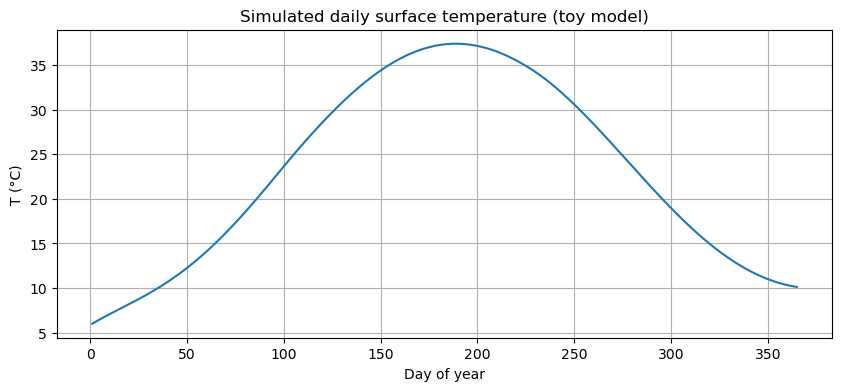

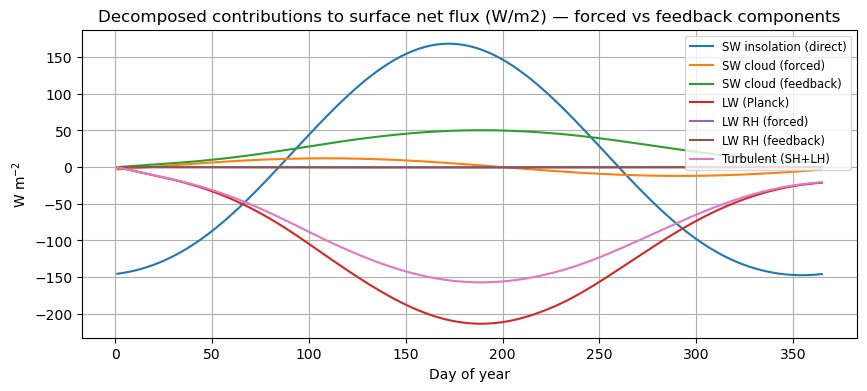

Rough seasonal amplitude (peak-to-peak) of contributions (W/m2):
LW_planck               213.403565
SW_insolation_direct    168.040014
Turbulent               157.057062
Net_flux                 60.629446
SW_cloud_feedback        50.258260
SW_cloud_forced          11.999889
LW_cloud_feedback         9.423424
LW_cloud_forced           2.249979
LW_RH_feedback            0.628228
LW_RH_forced              0.159999


In [2]:
# Run the toy model for a mid-latitude site (St Andrews-like ~56N)
results = run_seasonal_model(latitude=56.34, year_days=365, C=2.0e7, T0=273.15+6.0)

# Plot results: follow python_user_visible rules: use matplotlib, single plot per figure, no seaborn, no preset colors.
state = results["state"]
contribs = results["contribs"]
decomp = results["decomp"]

plt.figure(figsize=(10,4))
plt.plot(state.index, state["T"] - 273.15)  # Celsius
plt.title("Simulated daily surface temperature (toy model)")
plt.ylabel("T (°C)")
plt.xlabel("Day of year")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(decomp.index, decomp["SW_insolation_direct"], label="SW insolation (direct)")
plt.plot(decomp.index, decomp["SW_cloud_forced"], label="SW cloud (forced)")
plt.plot(decomp.index, decomp["SW_cloud_feedback"], label="SW cloud (feedback)")
plt.plot(decomp.index, decomp["LW_planck"], label="LW (Planck)")
plt.plot(decomp.index, decomp["LW_RH_forced"], label="LW RH (forced)")
plt.plot(decomp.index, decomp["LW_RH_feedback"], label="LW RH (feedback)")
plt.plot(decomp.index, decomp["Turbulent"], label="Turbulent (SH+LH)")
plt.title("Decomposed contributions to surface net flux (W/m2) — forced vs feedback components")
plt.xlabel("Day of year")
plt.ylabel("W m$^{-2}$")
plt.legend(loc="upper right", fontsize="small")
plt.grid(True)
plt.show()

# Also produce a stacked-like view for the magnitudes (absolute seasonal amplitude)
amps = decomp.abs().max() - decomp.abs().min()
amps = amps.sort_values(ascending=False)
print("Rough seasonal amplitude (peak-to-peak) of contributions (W/m2):")
print(amps.to_string())

# Provide outputs as dataframes for inspection
# import caas_jupyter_tools as cjt
# cjt.display_dataframe_to_user("Model state (daily)", state)
# cjt.display_dataframe_to_user("Contributions (daily)", contribs)
# cjt.display_dataframe_to_user("Decomposition (daily)", decomp)

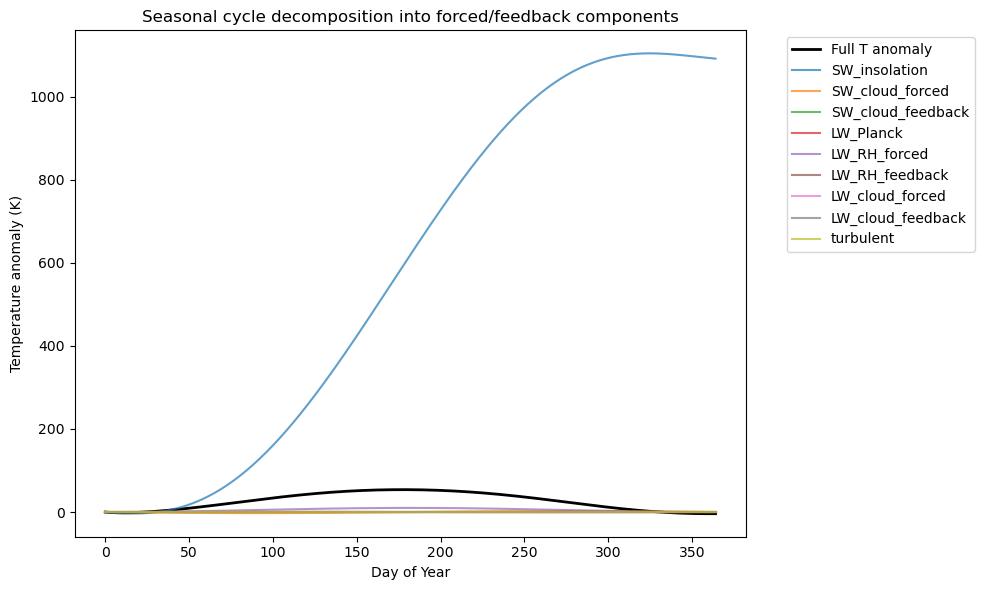

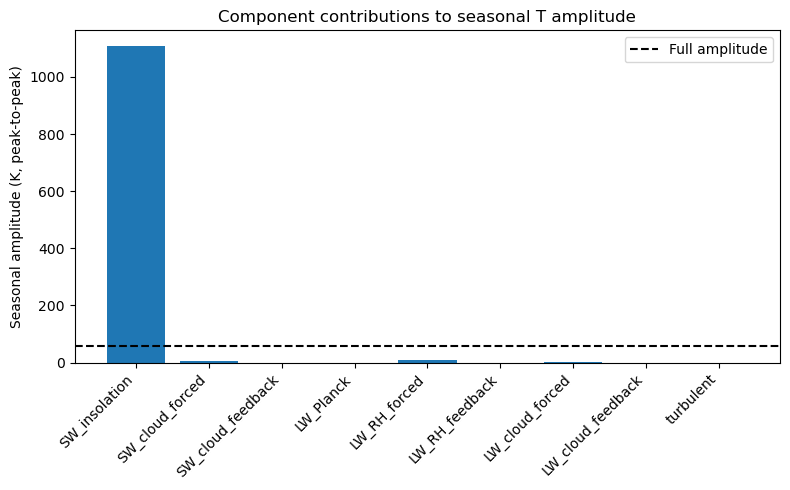

In [3]:
# Parameters
days = np.arange(365)
lat = 45.0 * np.pi / 180  # latitude in radians
C = 1e7  # mixed layer heat capacity J/m²/K
dt = 86400  # one day in seconds

# Orbital parameters
def daily_insolation(day, lat):
    # Declination angle
    decl = 23.44 * np.pi / 180 * np.sin(2 * np.pi * (day - 80) / 365)
    # Day length fraction
    cosH = -np.tan(lat) * np.tan(decl)
    cosH = np.clip(cosH, -1, 1)
    H = np.arccos(cosH)
    daylength = 2 * H / (2 * np.pi)
    # TOA insolation (simplified)
    S0 = 1361
    return S0 * (daylength * np.cos(lat) * np.cos(decl) + np.sin(lat) * np.sin(decl))

S = np.array([daily_insolation(d, lat) for d in days])
transmissivity_clear = 0.75

# Kernel parameters (toy values)
K_cloud_SW = -50.0    # W/m2 per unit cloud fraction
K_RH_LW = 2.0         # W/m2 per %RH anomaly
K_cloud_LW = 15.0     # W/m2 per unit cloud fraction
k_turbulent = 10.0    # W/m2/K
sigma = 5.67e-8

# Reference state
T_ref = 288.0
RH_ref = 0.7
cloud_ref = 0.4

# Seasonal forcing terms (toy sinusoids)
RH_forced = RH_ref + 0.05 * np.sin(2 * np.pi * days / 365)
cloud_forced = cloud_ref + 0.1 * np.cos(2 * np.pi * days / 365)

# Feedback sensitivities
RH_feedback_perK = 0.01
cloud_feedback_perK = -0.005

# Helper function: integrate with chosen active components
def integrate_model(active):
    T = np.zeros_like(days, dtype=float)
    T[0] = T_ref
    for t in range(1, len(days)):
        Ts = T[t-1]
        RH = RH_forced[t] + RH_feedback_perK * (Ts - T_ref)
        cloud = cloud_forced[t] + cloud_feedback_perK * (Ts - T_ref)

        flux = 0.0
        if "SW_insolation" in active:
            flux += S[t] * transmissivity_clear
        if "SW_cloud_forced" in active:
            flux += K_cloud_SW * (cloud_forced[t] - cloud_ref)
        if "SW_cloud_feedback" in active:
            flux += K_cloud_SW * (cloud - cloud_forced[t])
        if "LW_Planck" in active:
            flux -= 4 * sigma * T_ref**3 * (Ts - T_ref)
        if "LW_RH_forced" in active:
            flux += K_RH_LW * ((RH_forced[t] - RH_ref) * 100)
        if "LW_RH_feedback" in active:
            flux += K_RH_LW * ((RH - RH_forced[t]) * 100)
        if "LW_cloud_forced" in active:
            flux += K_cloud_LW * (cloud_forced[t] - cloud_ref)
        if "LW_cloud_feedback" in active:
            flux += K_cloud_LW * (cloud - cloud_forced[t])
        if "turbulent" in active:
            flux -= k_turbulent * (Ts - T_ref)

        T[t] = Ts + flux * dt / C
    return T

# Full model run (all components)
all_components = ["SW_insolation", "SW_cloud_forced", "SW_cloud_feedback",
                  "LW_Planck", "LW_RH_forced", "LW_RH_feedback",
                  "LW_cloud_forced", "LW_cloud_feedback", "turbulent"]
T_full = integrate_model(all_components)

# Individual contributions
components = {
    "SW_insolation": ["SW_insolation"],
    "SW_cloud_forced": ["SW_cloud_forced"],
    "SW_cloud_feedback": ["SW_cloud_feedback"],
    "LW_Planck": ["LW_Planck"],
    "LW_RH_forced": ["LW_RH_forced"],
    "LW_RH_feedback": ["LW_RH_feedback"],
    "LW_cloud_forced": ["LW_cloud_forced"],
    "LW_cloud_feedback": ["LW_cloud_feedback"],
    "turbulent": ["turbulent"]
}

T_components = {name: integrate_model(active) for name, active in components.items()}

# Normalize contributions so they sum to full anomaly
T_anom_full = T_full - T_ref
T_anom_comp = {k: v - T_ref for k, v in T_components.items()}

# Plot time series
plt.figure(figsize=(10,6))
plt.plot(days, T_anom_full, 'k', label="Full T anomaly", linewidth=2)
for k, v in T_anom_comp.items():
    plt.plot(days, v, label=k, alpha=0.7)
plt.xlabel("Day of Year")
plt.ylabel("Temperature anomaly (K)")
plt.title("Seasonal cycle decomposition into forced/feedback components")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Compute amplitudes (peak-to-peak)
amp_full = T_anom_full.max() - T_anom_full.min()
amp_components = {k: v.max() - v.min() for k, v in T_anom_comp.items()}

# Bar plot
plt.figure(figsize=(8,5))
plt.bar(range(len(amp_components)), list(amp_components.values()), tick_label=list(amp_components.keys()))
plt.axhline(amp_full, color="k", linestyle="--", label="Full amplitude")
plt.ylabel("Seasonal amplitude (K, peak-to-peak)")
plt.title("Component contributions to seasonal T amplitude")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

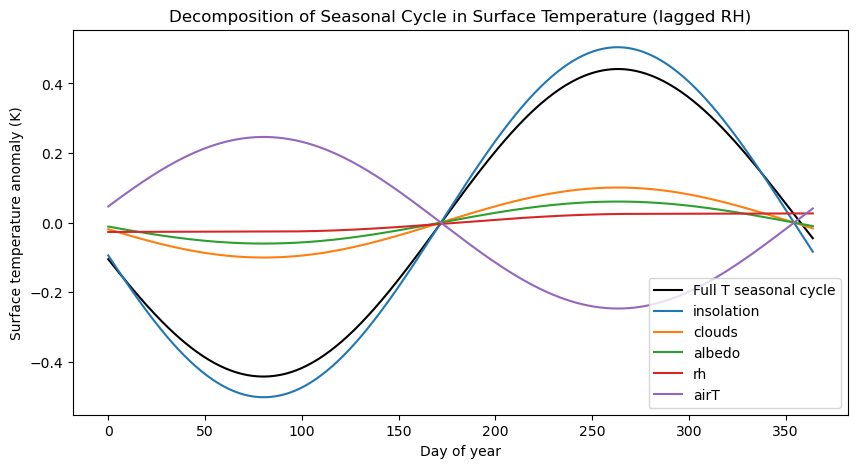

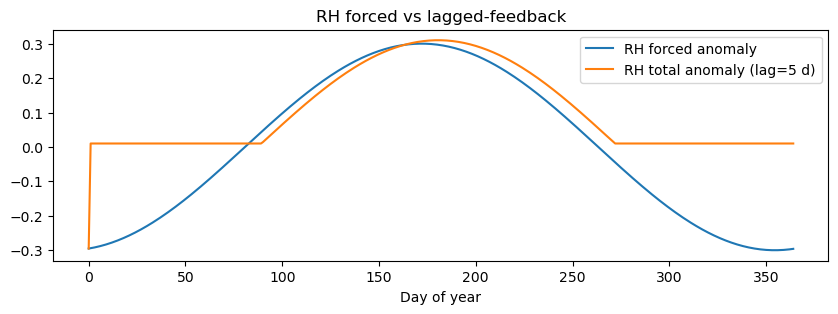

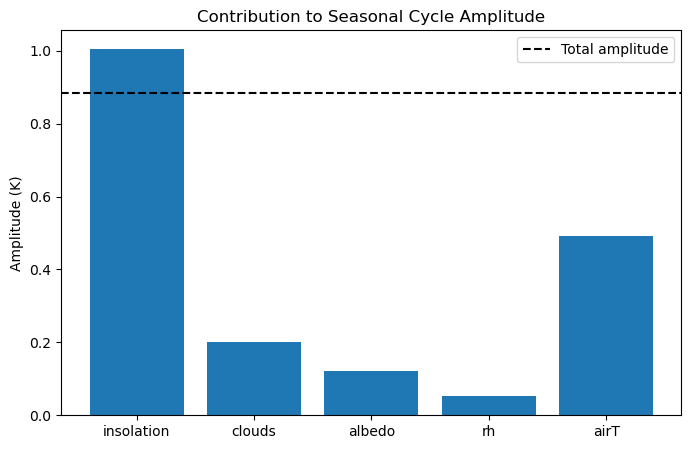

Total seasonal amplitude: 0.8836767583021279 K


In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Time setup (days)
days = np.arange(365)
omega = 2 * np.pi / 365

# Effective heat capacity (J/m2/K) ~ land mixed layer
C = 5e7

# Kernels (tuned values, W/m2 per unit perturbation)
K_insol = 5.0       # Insolation forcing
K_cloud = -2.0      # Clouds reduce SW at surface
K_albedo = -1.2     # Surface albedo feedback
K_rh = 0.8          # Low-level RH greenhouse effect
K_ta = -3.5         # Near-surface air T damping (LW + turbulent)

# External drivers (nondimensional seasonal cycles)
insol = np.cos(omega * (days - 172))   # peak at summer solstice
cloud_forced = -0.5 * insol                   # fewer clouds in summer
albedo_forced = -0.5 * insol                  # snow-albedo feedback
rh_forced = 0.3 * insol                       # higher RH in summer
ta_forced = 0.7 * insol                       # air T tracks surface cycle

# Feedback parameters
alpha_rh = 0.1   # RH change per K of past surface warming (fraction per K)
lag_days = 5      # lag in days: RH(t) responds to T(t - lag_days)

# Collect for looping
drivers = {
    'insolation': (K_insol, insol),
    'clouds': (K_cloud, cloud_forced),
    'albedo': (K_albedo, albedo_forced),
    'rh': (K_rh, None),   # RH driver will be computed inside integration (depends on lagged T)
    'airT': (K_ta, ta_forced)
}

# Function to integrate surface energy balance with lagged RH feedback
def run_model_with_lag(drivers, C, days, alpha_rh=0.01, lag_days=0):
    dt = 86400  # 1 day in seconds
    T = np.zeros(len(days))
    RH = np.zeros(len(days))

    # initialize RH to forced climatology for first few days
    for t in range(len(days)):
        RH[t] = rh_forced[t]

    for t in range(1, len(days)):
        # compute RH feedback from lagged surface temperature
        lag_index = t - lag_days
        if lag_index < 0:
            T_lag_anom = 0.0
        else:
            T_lag_anom = T[lag_index]  # T is anomaly relative to mean (we'll keep it consistent)
        RH[t] = rh_forced[t] + alpha_rh * T_lag_anom
        RH[t] = np.clip(RH[t], 0.01, 0.99)

        flux = 0.0
        # insolation (use drivers entry directly)
        K, x = drivers['insolation']
        flux += K * x[t]
        # clouds
        K, x = drivers['clouds']
        flux += K * x[t]
        # albedo
        K, x = drivers['albedo']
        flux += K * x[t]
        # RH (use computed RH anomaly relative to mean of forced)
        K, _ = drivers['rh']
        rh_anom = RH[t] - np.mean(rh_forced)
        flux += K * rh_anom
        # air temperature coupling (treated as forcing here)
        K, x = drivers['airT']
        flux += K * x[t]

        # integrate
        dT = (flux / C) * dt
        T[t] = T[t-1] + dT

    # return anomalies relative to annual mean
    T_anom = T - np.mean(T)
    return T_anom, RH - np.mean(rh_forced)

# Full run with lagged RH feedback
T_full, RH_full = run_model_with_lag(drivers, C, days, alpha_rh=alpha_rh, lag_days=lag_days)

# Suppress each mechanism (set kernel to zero) and re-run
contribs = {}
for key in drivers:
    drivers_mod = drivers.copy()
    if key == 'rh':
        drivers_mod['rh'] = (0.0, None)
        T_mod, _ = run_model_with_lag(drivers_mod, C, days, alpha_rh=alpha_rh, lag_days=lag_days)
    else:
        drivers_mod[key] = (0.0, drivers_mod[key][1])
        T_mod, _ = run_model_with_lag(drivers_mod, C, days, alpha_rh=alpha_rh, lag_days=lag_days)
    contribs[key] = T_full - T_mod

# Plot seasonal cycle decomposition
plt.figure(figsize=(10,5))
plt.plot(days, T_full, 'k', label='Full T seasonal cycle')
for key, contrib in contribs.items():
    plt.plot(days, contrib, label=key)
plt.xlabel('Day of year')
plt.ylabel('Surface temperature anomaly (K)')
plt.legend()
plt.title('Decomposition of Seasonal Cycle in Surface Temperature (lagged RH)')
plt.show()

# Plot RH and its lagged relation
plt.figure(figsize=(10,3))
plt.plot(days, rh_forced - np.mean(rh_forced), label='RH forced anomaly')
plt.plot(days, RH_full, label=f'RH total anomaly (lag={lag_days} d)')
plt.legend()
plt.title('RH forced vs lagged-feedback')
plt.xlabel('Day of year')
plt.show()

# Bar plot of amplitudes
plt.figure(figsize=(8,5))
ampls = [np.ptp(contrib) for contrib in contribs.values()]
plt.bar(contribs.keys(), ampls)
plt.axhline(np.ptp(T_full), color='k', linestyle='--', label='Total amplitude')
plt.ylabel('Amplitude (K)')
plt.title('Contribution to Seasonal Cycle Amplitude')
plt.legend()
plt.show()

print("Total seasonal amplitude:", np.ptp(T_full), "K")


### Scematic 1
Breakdown contribution of surface temperature seasonal cycle into the contribution of the different mechanisms, for a given region.

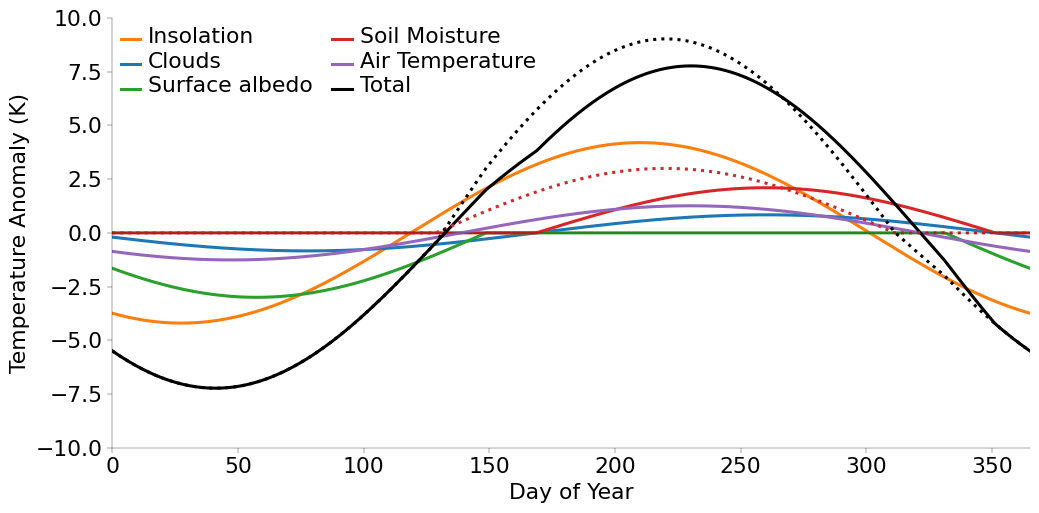

In [188]:
import numpy as np
import matplotlib.pyplot as plt

# Time axis (day of year)
days = np.linspace(0, 365, 366)

# Insolation: peaks ~day 172 (NH summer solstice)
insolation = 10.0 * np.cos(2 * np.pi * (days - 210) / 365)

# Clouds: more clouds in winter, offsetting insolation
clouds = 2.0 * np.cos(2 * np.pi * (days - 260) / 365)  # strongest around midsummer
# clouds = np.where(clouds < 0, clouds, 0)

# Relative humidity: anticorrelated with surface T (low in summer, high in winter)
albedo = 3 * np.cos(2 * np.pi * (days - 240) / 365)  # shifted later than insolation
albedo = np.where(albedo < 0, albedo, 0)

# Soil moisture: damps peak summer warming, lags behind insolation peak
soil = 5 * np.cos(2 * np.pi * (days - 260) / 365)
soil = np.where(soil > 0, soil, 0)

# Air temperature: lags surface temperature slightly, reinforces total
air = 3.0 * np.cos(2 * np.pi * (days - 230) / 365)

# Combine contributions
total = insolation + clouds + albedo + soil + air

soil2 = 3 * np.cos(2 * np.pi * (days - 220) / 365)
soil2 = np.where(soil2 > 0, soil2, 0)


# Scale so that total amplitude is ~15 K
amp = total.max() - total.min()
scaling = 15.0 / amp
insolation *= scaling
clouds *= scaling
rh *= scaling
soil *= scaling
air *= scaling
total *= scaling

# Plot
fig = plt.figure(figsize=(10, 5))
plt.plot(days, insolation, label="Insolation", color="C1")
plt.plot(days, clouds, label="Clouds", color="C0")
plt.plot(days, albedo, label="Surface albedo", color="C2")
plt.plot(days, soil, label="Soil Moisture", color="C3")
plt.plot(days, air, label="Air Temperature", color="C4")
plt.plot(days, total, label="Total", color="black")
plt.plot(days, soil2, color="C3", linestyle=':')
plt.plot(days, total-soil + soil2, color="black", linestyle=':')

plt.xlabel("Day of Year")
plt.ylabel("Temperature Anomaly (K)")
# plt.title("Schematic Contributions to Seasonal Cycle of Surface Temperature (NH)")
update_linewidth(fig, base_linewidth=0.7)
plt.legend(ncol=2)
update_fontsize(fig, base_fontsize=5)
plt.gca().axhline(0, color='k', lw=ax_linewidth)
# plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.gca().set_xlim(0, 365)
plt.gca().set_ylim(-10, 10)
plt.show()
savefig(fig)

### Schematic 2: Mechanism responsible for amplitude
Create simple schematic indicating mechanism other than insolation responsible for the amplitude of the seasonal cycle.

In [142]:
import os
import xarray as xr
data_dir = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/3_hour/hottest_time'
exp_name = 'pre_industrial'
ds = xr.load_dataset(os.path.join(data_dir, exp_name, 'output.nc'))

# Land masks
# The year for the land-sea mask matters. Not surprising due to glaciers melting. Zhang used 1979 mask.
invariant_data = xr.open_dataset('/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc')[['LANDFRAC', 'PHIS']]
invariant_data = invariant_data.reindex_like(ds['PS'], method="nearest", tolerance=0.01).load()
# lsm = lsm_zhang
land = invariant_data['LANDFRAC'].where(invariant_data['LANDFRAC']>0.5)*0+1

In [167]:
air_temperature = (ds.TREFHT>0).astype(int)
clouds = ((ds.FSDSC - ds.FSDS)>10).astype(int)
soil_moisture = (ds.LHFLX<100).astype(int)
surface_albedo = ((ds.Z3.isel(lev=-1)>1500) + (ds.TREFHT<290)).astype(int).clip(0, 1)
mechanism = air_temperature * 4
mechanism = xr.where(clouds>0, 0, mechanism)
mechanism = xr.where(soil_moisture>0, 3, mechanism)
mechanism = xr.where(surface_albedo, 2, mechanism)

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:844: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:850: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xy = np.append(intersection[0], intersection[-1],
/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:850: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  xy = np.append(intersection[0], intersection[-1],
/Users/j

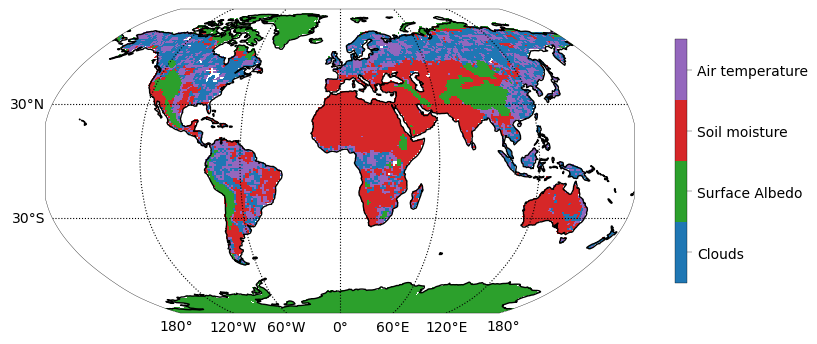

In [181]:
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors

def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180,180.01,60), grid_lat=np.asarray([-30, 30])):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels=0
    gl.top_labels=0
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    return ax

def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=land, cmap='viridis'):
    data, lon = add_cyclic_point(var * (1 if mask is None else mask), coord=var.lon.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.lat.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

fig = plt.figure(constrained_layout=True)
ax = fig.subplots(1,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
fig_resize(fig, 10, ar=3)
initialize_ax_projection(ax, lat_min=-90, lat_max=90)

categories = [0, 2, 3, 4]
colors = ['C0', 'C2', 'C3', 'C4']
cat_name = ['Clouds', 'Surface Albedo', 'Soil moisture', 'Air temperature']
cmap = mcolors.ListedColormap(colors)  # discrete colormap with 6 colors
norm = mcolors.BoundaryNorm(boundaries=np.array(categories + [max(categories)+1])-0.5,
                            ncolors=len(categories))
im = mechanism.where(land>0).plot.imshow(ax=ax, cmap=cmap, norm=norm, add_colorbar=False,
                                                                                transform=ccrs.PlateCarree(), interpolation='none')
# Custom colorbar with labels
cbar = fig.colorbar(im, ax=ax, ticks=[0.5, 2, 3, 4], shrink=0.8)
cbar.ax.set_yticklabels(cat_name)
cbar.ax.tick_params(labelsize=10)
ax.set_title('')
plt.show()
# savefig(fig)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.7921e+06                                    2.89e+05    
       1              2         5.4193e+06      2.37e+06       7.50e+00       2.25e+05    
       2              3         2.5005e+06      2.92e+06       1.50e+01       1.46e+05    
       3              4         3.5496e+05      2.15e+06       3.00e+01       6.02e+04    
       4              5         5.9929e+01      3.55e+05       7.18e+00       7.16e+02    
       5              6         9.3957e+00      5.05e+01       8.98e-02       7.54e-01    
       6              7         9.3956e+00      1.01e-04       1.27e-04       5.83e-05    
       7              8         9.3956e+00      2.31e-14       8.97e-09       4.75e-05    
       8              9         9.3956e+00      0.00e+00       0.00e+00       4.75e-05    
`xtol` termination condition is satisfied.
Function evaluations 9, initial cost 7.7921e+06

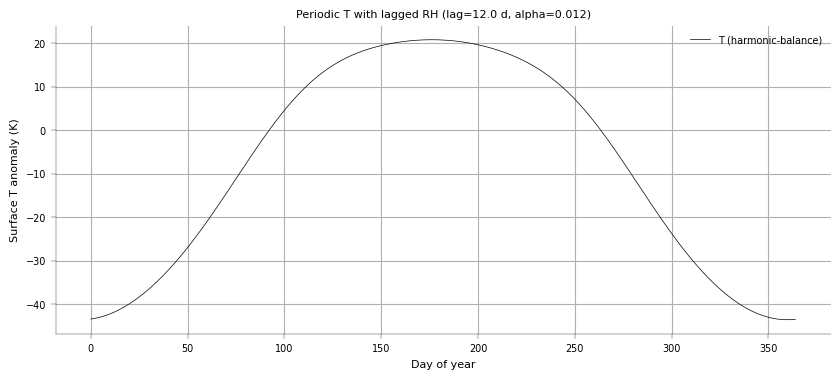

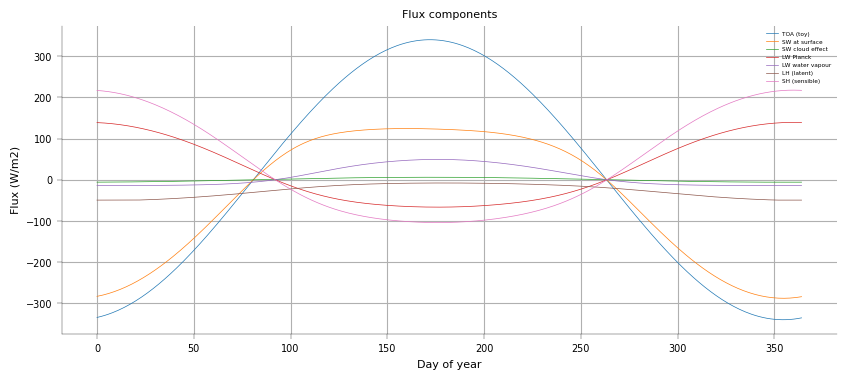

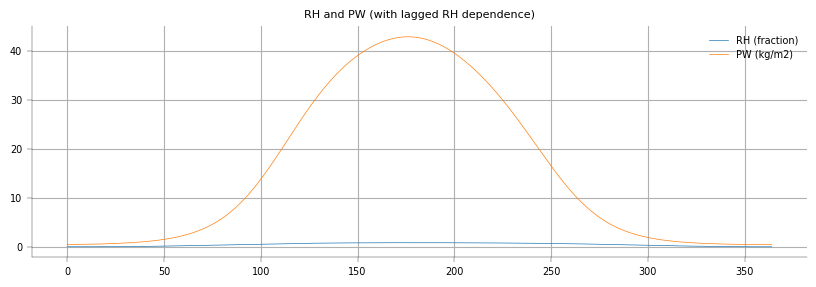

Peak-to-peak T amplitude (K): 64.3193042309184
Residual norm (W/m2): 4.334884433812536


In [183]:
#!/usr/bin/env python3
"""
Harmonic-balance solver for a periodic surface-energy ODE with lagged RH feedback.

Usage:
    python harmonic_balance_lagged_rh.py

Dependencies:
    numpy, scipy, matplotlib
"""

from typing import Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# -------------------- spectral helpers --------------------
def cos_series_to_time(coefs: np.ndarray, M: int) -> np.ndarray:
    """
    Convert cosine-sine coefficients [a0, a1, b1, a2, b2, ...] to a time-series length M.

    Args:
        coefs: array of length (2*nh + 1) with layout [a0, a1, b1, a2, b2, ...].
        M: number of samples across the period.

    Returns:
        ts: time-series (length M).
    """
    t = np.linspace(0, 1, M, endpoint=False)
    ts = np.zeros(M) + coefs[0]
    nh = (len(coefs) - 1) // 2
    idx = 1
    for k in range(1, nh + 1):
        a_k = coefs[idx]; b_k = coefs[idx + 1]
        ts += a_k * np.cos(2.0 * np.pi * k * t) + b_k * np.sin(2.0 * np.pi * k * t)
        idx += 2
    return ts

def time_derivative_fft(ts: np.ndarray, period_days: float) -> np.ndarray:
    """
    Compute the time derivative d/dt of ts (sampled uniformly over period_days) using an exact spectral derivative.

    Args:
        ts: time series (length M).
        period_days: period in days.

    Returns:
        dts/dt array (same length M) in units K/day (if ts in K).
    """
    M = len(ts)
    Ts_hat = np.fft.rfft(ts)
    # integer mode numbers 0..M/2
    n = np.fft.rfftfreq(M) * M
    omega_n = 2.0 * np.pi * n / period_days  # rad/day
    deriv_hat = 1j * omega_n * Ts_hat
    dts = np.fft.irfft(deriv_hat, n=M)
    return dts

# -------------------- physical helpers --------------------
def pw_from_T(T_abs: np.ndarray, PW0: float = 10.0, gamma: float = 0.07, T0: float = 288.0) -> np.ndarray:
    """
    Estimate precipitable water (kg/m2) from absolute surface temperature (K).
    Clausius–Clapeyron-like exponential scaling.

    Args:
        T_abs: absolute surface temperature array (K).
        PW0: reference PW at T0 (kg/m2).
        gamma: fractional PW growth per K (typical 0.06-0.08).
        T0: reference temperature (K).

    Returns:
        PW array (kg/m2).
    """
    return PW0 * np.exp(gamma * (T_abs - T0))

def transmissivity(PW: np.ndarray, T0_trans: float = 0.7, a_pw: float = 0.02) -> np.ndarray:
    """
    Simple transmissivity model decreasing with PW.

    Args:
        PW: precipitable water (kg/m2).
        T0_trans: reference transmissivity.
        a_pw: sensitivity coefficient per kg/m2.

    Returns:
        transmissivity array (dimensionless).
    """
    return T0_trans * np.exp(-a_pw * (PW - 10.0))

# -------------------- flux model with lagged RH --------------------
def flux_with_lagged_RH(t_days: np.ndarray, T_time: np.ndarray,
                        lag_days: float = 7.0, alpha_rh: float = 0.01) -> Tuple[np.ndarray, Dict]:
    """
    Compute net surface flux F(t,T) using a lagged RH: RH(t) = RH_forced(t) + alpha_rh * T(t - lag_days).

    Args:
        t_days: time array in days over one period (length M).
        T_time: surface temperature time-series (K anomaly about reference T0=288 K).
        lag_days: lag for RH response in days (positive -> RH follows past T).
        alpha_rh: RH response coefficient (fraction per K).

    Returns:
        F: net flux array (W/m2)
        comps: dictionary of component arrays for diagnostics
    """
    # period length and sample spacing
    P = t_days[-1] + (t_days[1] - t_days[0])
    M = len(t_days)

    # Toy TOA seasonal forcing (W/m2) — smooth NH-like peak at day 172
    TOA = 340.0 * np.cos(2.0 * np.pi * (t_days - 172.0) / P)

    # RH forced seasonal climatology (fraction)
    RH_forced = 0.55 + 0.05 * np.cos(2.0 * np.pi * (t_days - 150.0) / P)

    # Build lagged T vector T(t - lag_days) by periodic interpolation
    t_shift = (t_days - lag_days) % P
    T_shift = np.interp(t_shift, t_days, T_time)  # assumes T_time corresponds to t_days

    # RH with lagged feedback
    RH = RH_forced + alpha_rh * T_shift
    RH = np.clip(RH, 0.01, 0.99)

    # Absolute temperature used for PW estimate
    T_abs = 288.0 + T_time
    PW = pw_from_T(T_abs)  # kg/m2

    # SW reaching surface (transmissivity * TOA)
    trans = transmissivity(PW)
    SW = trans * TOA

    # Cloud contribution: simple prescribed small seasonal cloud fraction (positive in winter)
    clouds_frac = 0.1 * np.cos(2.0 * np.pi * (t_days - 355.0) / P)  # fraction anomaly
    K_cloud_sw = -60.0  # W/m2 per unit cloud fraction
    SW_cloud = K_cloud_sw * clouds_frac

    # LW: linearized Planck cooling term plus WV enhancement
    lambda_planck = 3.2  # W/m2/K (toy Planck-like)
    LW_planck = -lambda_planck * T_time
    LW_wv = 1.5 * (PW - 10.0)  # additional downwelling from extra PW (W/m2)

    # Latent heat: assume evaporation stronger when RH low -> more cooling (negative flux)
    # Use a simple empirical formula: LH = -L0 * (1 - RH) (W/m2)
    L0 = 50.0
    LH = -L0 * (1.0 - RH)

    # Sensible heat: small linear damping proportional to T anomaly
    SH = -5.0 * T_time

    # Net flux (positive warms)
    F = SW + SW_cloud + LW_planck + LW_wv + LH + SH

    comps = {
        "TOA": TOA, "trans": trans, "SW": SW, "clouds_frac": clouds_frac, "SW_cloud": SW_cloud,
        "PW": PW, "RH": RH, "LW_planck": LW_planck, "LW_wv": LW_wv, "LH": LH, "SH": SH
    }
    return F, comps

# -------------------- harmonic-balance solver --------------------
def harmonic_balance_with_lag(period_days: float = 365.0, nh: int = 6,
                              lag_days: float = 7.0, alpha_rh: float = 0.01,
                              C: float = 5.0e6, verbose: bool = True) -> Tuple[np.ndarray, np.ndarray, Dict]:
    """
    Solve C dT/dt = F(t,T) for a periodic T(t) using harmonic balance,
    where RH depends on lagged T.

    Args:
        period_days: length of period (days).
        nh: number of harmonics to include.
        lag_days: lag for RH feedback (days).
        alpha_rh: RH sensitivity (fraction per K) to lagged T.
        C: effective heat capacity (J/m2/K).
        verbose: pass to least_squares for printout.

    Returns:
        t_days: collocation times (days)
        T_sol: solved periodic surface temperature anomaly (K)
        diagnostics: dict with coefficients, fluxes, components
    """
    M = max(4 * nh + 1, 365)  # collocation points (daily resolution min)
    t_days = np.linspace(0.0, period_days, M, endpoint=False)

    # initial guess coefficients [a0, a1, b1, a2, b2, ...]
    a0 = 0.0
    a1 = 7.5  # K guess
    b1 = 0.0
    coefs0 = [a0, a1, b1] + [0.0] * (2 * (nh - 1))
    coefs0 = np.array(coefs0)

    def coefs_to_time(coefs):
        return cos_series_to_time(coefs, M)

    def residuals(coefs):
        T_time = coefs_to_time(coefs)
        dTdt = time_derivative_fft(T_time, period_days)  # K/day
        # convert derivative units to K/day -> but flux units are W/m2; keep consistent by using C in J/m2/K and time in days
        # since derivative is dT/dt (K/day), multiply by C and divide by seconds/day to get W/m2
        sec_per_day = 86400.0
        dTdt_sec = dTdt / sec_per_day  # K/s
        F, _ = flux_with_lagged_RH(t_days, T_time, lag_days=lag_days, alpha_rh=alpha_rh)
        R = C * dTdt_sec - F  # residual in W/m2
        return R

    sol = least_squares(residuals, coefs0, method='trf', verbose=2 if verbose else 0,
                        xtol=1e-10, ftol=1e-10, gtol=1e-10, max_nfev=3000)
    coefs_sol = sol.x
    T_sol = cos_series_to_time(coefs_sol, M)
    F_sol, comps = flux_with_lagged_RH(t_days, T_sol, lag_days=lag_days, alpha_rh=alpha_rh)
    diagnostics = {"coefs": coefs_sol, "F": F_sol, "comps": comps, "residual_norm": np.linalg.norm(sol.fun)}
    return t_days, T_sol, diagnostics

# -------------------- run demo and plot --------------------
if __name__ == "__main__":
    # parameters you can tune
    period_days = 365.0
    nh = 6
    lag_days = 12.0       # RH lags surface by 12 days
    alpha_rh = 0.012      # RH change per K of lagged T (fraction per K)
    C = 3.0e6             # effective heat capacity (J/m2/K) - tuned for visible amplitude

    t_days, T_sol, diag = harmonic_balance_with_lag(period_days=period_days, nh=nh,
                                                   lag_days=lag_days, alpha_rh=alpha_rh, C=C, verbose=True)

    comps = diag["comps"]
    F = diag["F"]

    # Plots
    plt.figure(figsize=(10,4))
    plt.plot(t_days, T_sol, 'k', label='T (harmonic-balance)')
    plt.xlabel('Day of year'); plt.ylabel('Surface T anomaly (K)')
    plt.title(f'Periodic T with lagged RH (lag={lag_days} d, alpha={alpha_rh})')
    plt.grid(True); plt.legend()

    plt.figure(figsize=(10,4))
    plt.plot(t_days, comps['TOA'], label='TOA (toy)')
    plt.plot(t_days, comps['SW'], label='SW at surface')
    plt.plot(t_days, comps['SW_cloud'], label='SW cloud effect')
    plt.plot(t_days, comps['LW_planck'], label='LW Planck')
    plt.plot(t_days, comps['LW_wv'], label='LW water vapour')
    plt.plot(t_days, comps['LH'], label='LH (latent)')
    plt.plot(t_days, comps['SH'], label='SH (sensible)')
    plt.xlabel('Day of year'); plt.ylabel('Flux (W/m2)'); plt.title('Flux components'); plt.legend(loc='upper right', fontsize='small'); plt.grid(True)

    plt.figure(figsize=(10,3))
    plt.plot(t_days, comps['RH'], label='RH (fraction)')
    plt.plot(t_days, comps['PW'], label='PW (kg/m2)')
    plt.legend(); plt.title('RH and PW (with lagged RH dependence)'); plt.grid(True)

    plt.show()

    print("Peak-to-peak T amplitude (K):", np.ptp(T_sol))
    print("Residual norm (W/m2):", diag["residual_norm"])


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.0974e+02                                    2.76e+02    
       1              3         7.9670e+02      1.30e+01       8.57e+00       4.66e+02    
       2              4         7.9006e+02      6.64e+00       8.57e+00       8.04e+01    
       3              5         7.8995e+02      1.07e-01       1.05e+00       3.72e+01    
       4              8         7.8989e+02      6.10e-02       1.35e-01       2.87e+01    
       5              9         7.8988e+02      5.36e-03       1.35e-01       3.92e+01    
       6             10         7.8986e+02      2.16e-02       3.38e-02       1.47e+01    
       7             11         7.8986e+02      5.82e-04       3.38e-02       1.40e+01    
       8             12         7.8986e+02      3.43e-03       8.44e-03       6.13e+00    
       9             13         7.8986e+02      1.10e-03       8.44e-03       2.45e+00    

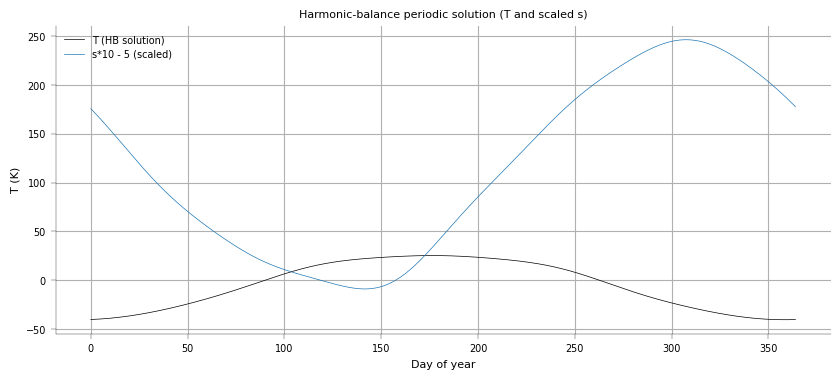

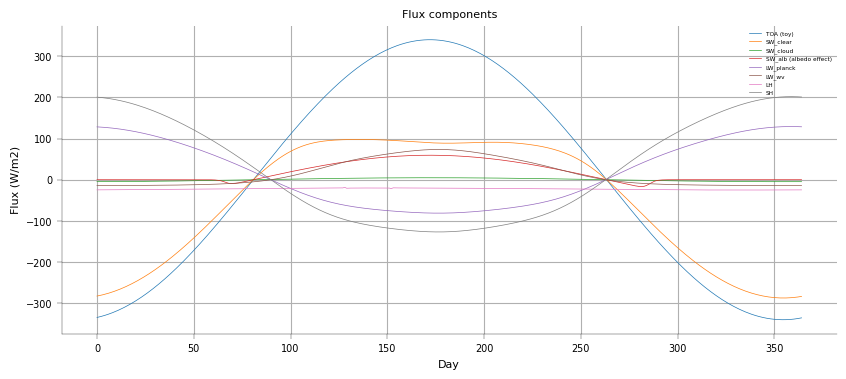

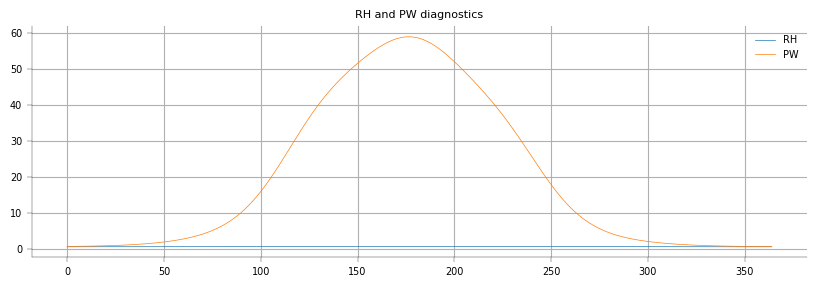

Residual norm (||R||): 39.745503532598995
Peak-to-peak T amplitude (K): 65.71388705606732


In [185]:
# Harmonic-balance solver with smooth snow-albedo and dynamic soil moisture (coupled ODEs)
# - Represents T(t) and s(t) (soil moisture index 0..1) with Fourier coefficients.
# - Residuals enforce C dT/dt = F(T,s,t) and ds/dt = G(T,s,t) at collocation points.
# - Smooth snow-albedo via tanh; soil moisture evolves via a smooth ODE (recharge - evap) so it can reach zero smoothly.
# - Provides time-stepping initialization (RK4) to produce a periodic guess, then refines with harmonic-balance.
#
# Google-style docstrings are used. Copy-paste into a .py or Jupyter cell and run.
# Requires: numpy, scipy, matplotlib
from typing import Tuple, Dict, Any
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# ---------- spectral helpers ----------
def cos_series_to_time(coefs: np.ndarray, M: int) -> np.ndarray:
    """
    Convert cosine-sine coefficients [a0, a1, b1, a2, b2, ...] to a time-series length M.

    Args:
        coefs: array of length (2*nh + 1) with layout [a0, a1, b1, a2, b2, ...].
        M: number of uniform samples across the period.

    Returns:
        ts: time-series (length M).
    """
    t = np.linspace(0, 1, M, endpoint=False)
    ts = np.zeros(M) + coefs[0]
    nh = (len(coefs) - 1) // 2
    idx = 1
    for k in range(1, nh + 1):
        a_k = coefs[idx]; b_k = coefs[idx + 1]
        ts += a_k * np.cos(2.0 * np.pi * k * t) + b_k * np.sin(2.0 * np.pi * k * t)
        idx += 2
    return ts

def time_derivative_fft(ts: np.ndarray, period_days: float) -> np.ndarray:
    """
    Compute the time derivative d/dt of ts (sampled uniformly over period_days) using spectral derivative.

    Args:
        ts: time series (length M).
        period_days: period in days.

    Returns:
        dts/dt array (same length M) in units K/day (if ts in K).
    """
    M = len(ts)
    Ts_hat = np.fft.rfft(ts)
    n = np.fft.rfftfreq(M) * M
    omega_n = 2.0 * np.pi * n / period_days  # rad/day
    deriv_hat = 1j * omega_n * Ts_hat
    dts = np.fft.irfft(deriv_hat, n=M)
    return dts

# ---------- physical parameterisations (smooth) ----------
def delta_albedo_from_T(T_abs: np.ndarray, A_snow: float = 0.35, Tm: float = 273.15, dT: float = 2.0) -> np.ndarray:
    """
    Smooth albedo change due to snow melt. Returns delta_albedo in [-A_snow, 0].

    Args:
        T_abs: absolute temperature array (K).
        A_snow: maximum albedo change when fully snow-covered.
        Tm: melt midpoint temperature in K (e.g. 273.15 K).
        dT: smoothing width (K).

    Returns:
        delta_albedo: array same length as T_abs.
    """
    return -A_snow * 0.5 * (1.0 + np.tanh((T_abs - Tm) / dT))

def pw_from_T(T_abs: np.ndarray, PW0: float = 10.0, gamma: float = 0.07, T0: float = 288.0) -> np.ndarray:
    """
    Estimate precipitable water (kg/m2) from absolute surface temperature (K).
    """
    return PW0 * np.exp(gamma * (T_abs - T0))

def transmissivity(PW: np.ndarray, T0_trans: float = 0.7, a_pw: float = 0.02) -> np.ndarray:
    """
    Simple transmissivity model decreasing with PW.
    """
    return T0_trans * np.exp(-a_pw * (PW - 10.0))

def soil_evap_rate(T: np.ndarray, RH: np.ndarray) -> np.ndarray:
    """
    Simple empirical evaporation driver (positive for stronger evap when warm & dry).
    Returns arbitrary units (will be scaled in G).
    """
    return np.maximum(0.0, (T - 273.15) * (1.0 - RH))  # K * (1-RH)

# ---------- coupled fluxes and soil dynamics ----------
def flux_and_soil_tendencies(t_days: np.ndarray, T_time: np.ndarray, s_time: np.ndarray,
                            params: Dict[str, Any]) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
    """
    Compute net flux F(t,T,s) (W/m2) and soil moisture tendency G(t,T,s) (in units of s/day) at collocation times.
    Args:
        t_days: time array (days) length M.
        T_time: surface temperature anomaly (K) relative to baseline T0 (so T_abs = T0 + T_time).
        s_time: soil moisture index (0..1) time series length M.
        params: dictionary of parameters controlling fluxes and soil ODE.

    Returns:
        F: net flux array (W/m2), length M
        G: soil ds/dt as array in units 1/day (so convert to per second later), length M
        comps: dict with diagnostic arrays
    """
    P = params.get("P", 365.0)  # get period explicitly from params
    M = len(t_days)
    T0 = params.get("T0", 288.0)
    T_abs = T0 + T_time  # absolute temp in K

    # TOA seasonal (toy)
    TOA = 340.0 * np.cos(2.0 * np.pi * (t_days - 172.0) / P)

    # PW and transmissivity depend on T_abs
    PW = pw_from_T(T_abs, PW0=params.get("PW0",10.0), gamma=params.get("gamma",0.07), T0=T0)
    trans = transmissivity(PW, T0_trans=params.get("T0_trans",0.7), a_pw=params.get("a_pw",0.02))
    SW_clear = trans * TOA

    # snow-albedo delta (smooth)
    delta_alb = delta_albedo_from_T(T_abs, A_snow=params.get("A_snow",0.35),
                                    Tm=params.get("Tm",273.15), dT=params.get("dT",2.0))
    # baseline albedo effect: reduce SW by albedo*TOA; delta_alb is negative on warming when snow melts -> increases SW
    SW_alb = - (delta_alb) * 0.5 * TOA  # factor 0.5 to represent average daily insolation distribution over surface; toy scaling

    # clouds: simple seasonal cloud fraction (could depend on RH/T later)
    clouds_frac = 0.08 * np.cos(2.0*np.pi*(t_days - 355.0)/P)  # more clouds in winter (~positive fraction)
    K_cloud_sw = params.get("K_cloud_sw", -60.0)
    SW_cloud = K_cloud_sw * clouds_frac

    # LW terms
    lambda_planck = params.get("lambda_planck", 3.2)
    LW_planck = -lambda_planck * T_time  # linearized about T0
    LW_wv = params.get("k_wv", 1.5) * (PW - params.get("PW0",10.0))

    # RH: simple lagged dependence on T_time (for this function assume RH_forced plus alpha * lagged T given externally)
    # here, we do not compute lag in this routine; caller should supply RH if needed. For simplicity assume RH climatology
    RH = 0.55 + 0.05 * np.cos(2.0 * np.pi * (t_days - 150.0) / P)  # fraction

    # Latent heat: depends on RH and soil moisture s_time; smooth cutoff as s->0 through multiplicative factor
    L0 = params.get("L0", 50.0)
    eps = params.get("s_eps", 1e-3)
    s_eff = s_time / (s_time + eps)  # smooth factor in [0,1]
    LH = -L0 * (1.0 - RH) * s_eff  # negative when evaporation cools surface

    # Sensible heat
    SH = -5.0 * T_time

    # Net SW = clear + cloud + albedo term
    SW = SW_clear + SW_cloud + SW_alb

    F = SW + LW_planck + LW_wv + LH + SH

    # Soil tendency G: model ds/dt (in 1/day units) as recharge - evap_loss
    # Recharge: simple seasonal precipitation proxy (mm/day scaled) -> convert to s units via param
    precip_amp = params.get("precip_amp", 0.5)  # arbitrary units per day
    precip = precip_amp * (1.0 + np.cos(2.0*np.pi*(t_days - 200.0)/P)) * 0.5  # non-negative seasonal recharge
    # Evap loss: proportional to empirical evaporation driver and modulated by (s/(s+eps))
    evap_driver = soil_evap_rate(T_abs, RH)  # arbitrary units
    k_evap = params.get("k_evap", 1e-2)  # tuning to get seasonal s variation
    evap_loss = k_evap * evap_driver * s_eff  # larger when s high and evaporative demand high
    # ds/dt in units 1/day: recharge - evap_loss (bounded but smooth)
    G = precip - evap_loss

    comps = {"TOA": TOA, "SW_clear": SW_clear, "SW_cloud": SW_cloud, "delta_alb": delta_alb,
             "SW_alb": SW_alb, "PW": PW, "trans": trans, "LW_planck": LW_planck,
             "LW_wv": LW_wv, "LH": LH, "SH": SH, "precip": precip, "evap_loss": evap_loss, "RH": RH}

    return F, G, comps

# ---------- time-stepping to obtain initial periodic guess ----------
def integrate_time_stepping(period_days: float, dt_days: float, years: int, C: float, params: Dict) -> Tuple[np.ndarray, np.ndarray, Dict[str, np.ndarray]]:
    """
    Integrate the coupled ODEs dT/dt = F/C and ds/dt = G using RK4 for a given number of years to approach periodic orbit.
    Returns last-year t_days, T_time, s_time and diagnostics averaged over final year.
    """
    total_days = int(years * period_days)
    N = int(total_days / dt_days)
    t_full = np.linspace(0.0, total_days, N, endpoint=False)
    T = np.zeros(N)
    s = np.ones(N) * 0.8  # start fairly wet
    # RK4 integration (simple)
    sec_per_day = 86400.0
    for n in range(N-1):
        t = t_full[n]
        # helper to compute derivatives in day units
        def derivs(t_local, Tval, sval):
            # map t_local to day within year
            tmod = t_local % period_days
            F, G, _ = flux_and_soil_tendencies(np.array([tmod]), np.array([Tval]), np.array([sval]), params)
            dTdt = F[0] / C  # in K per second? F in W/m2, C in J/m2/K, so F/C is K/s; convert to K/day multiply by sec/day
            dTdt_day = dTdt * sec_per_day  # K/day
            dsdtday = G[0]  # already in 1/day units as designed
            return dTdt_day, dsdtday

        Tn = T[n]; sn = s[n]
        h = dt_days
        k1T, k1s = derivs(t, Tn, sn)
        k2T, k2s = derivs(t + 0.5*h, Tn + 0.5*h*k1T, sn + 0.5*h*k1s)
        k3T, k3s = derivs(t + 0.5*h, Tn + 0.5*h*k2T, sn + 0.5*h*k2s)
        k4T, k4s = derivs(t + h, Tn + h*k3T, sn + h*k3s)
        T[n+1] = Tn + (h/6.0)*(k1T + 2*k2T + 2*k3T + k4T)
        s[n+1] = sn + (h/6.0)*(k1s + 2*k2s + 2*k3s + k4s)
        # keep s bounded smoothly (avoid hard clamp)
        s[n+1] = np.clip(s[n+1], 0.0, 1.0)

    # extract final year
    days_per_year = int(period_days / dt_days)
    last_idx = N - days_per_year
    t_year = np.linspace(0.0, period_days, days_per_year, endpoint=False)
    T_year = T[last_idx: last_idx + days_per_year]
    s_year = s[last_idx: last_idx + days_per_year]
    # compute diagnostics by computing comps across final year
    F_year, G_year, comps = flux_and_soil_tendencies(t_year, T_year, s_year, params)
    diagnostics = {"t_year": t_year, "T_year": T_year, "s_year": s_year, "F_year": F_year, "comps": comps}
    return t_year, T_year, s_year, diagnostics

# ---------- harmonic-balance residual assembly for coupled system ----------
def residuals_coupled(coefs: np.ndarray, period_days: float, nh: int, params: Dict) -> np.ndarray:
    """
    Build residual vector for coupled system represented by coefs for T and s:
    coefs layout: [a0_T, a1_T, b1_T, ..., a_nh_T, b_nh_T, a0_s, a1_s, b1_s, ..., a_nh_s, b_nh_s]
    Returns residuals concatenated [R_T (length M), R_s (length M)] where each are values of C dT/dt - F and ds/dt - G.
    """
    M = max(4*nh + 1, 365)
    t_days = np.linspace(0.0, period_days, M, endpoint=False)
    # split coefs
    mblock = 2*nh + 1
    coefs_T = coefs[:mblock]
    coefs_s = coefs[mblock: 2*mblock]
    T_time = cos_series_to_time(coefs_T, M)
    s_time = cos_series_to_time(coefs_s, M)
    # compute derivatives (in K/day and 1/day respectively)
    dTdt_day = time_derivative_fft(T_time, period_days)  # K/day
    dsdt_day = time_derivative_fft(s_time, period_days)  # 1/day
    # compute fluxes (F in W/m2) and G in 1/day via param function
    F, G, comps = flux_and_soil_tendencies(t_days, T_time, s_time, params)
    # convert dTdt_day to K/s for energy residual: dTdt_sec = dTdt_day / sec_per_day
    sec_per_day = 86400.0
    dTdt_sec = dTdt_day / sec_per_day
    # Residuals: C * dT/dt (K/s * J/m2/K = W/m2) - F = 0; and ds/dt (1/day) - G (1/day) = 0
    R_T = params["C"] * dTdt_sec - F
    R_s = dsdt_day - G  # both in 1/day
    R = np.concatenate([R_T, R_s])
    return R

# ---------- harmonic-balance solver wrapper ----------
def solve_harmonic_balance_coupled(period_days: float = 365.0, nh: int = 6,
                                   params: Dict[str, Any] = None, use_time_init: bool = True) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
    """
    Solve the coupled periodic problem for T(t) and s(t) using harmonic-balance with nh harmonics.
    Optionally initialize with time-stepping integration for several years to obtain a good initial guess.
    Returns collocation times t_days, solved T_time, s_time and diagnostics.
    """
    if params is None:
        params = {}
    # default parameters
    params.setdefault("C", 3.0e6)
    params.setdefault("T0", 288.0)

    M = max(4*nh + 1, 365)
    t_days = np.linspace(0.0, period_days, M, endpoint=False)
    mblock = 2*nh + 1

    # initial guess for coefs: use time-stepping to get initial periodic orbit if requested
    if use_time_init:
        t_init, T_init, s_init, diag_init = integrate_time_stepping(period_days, dt_days=1.0, years=6, C=params["C"], params=params)
        # compute Fourier coefficients (cos/sin) from last-year time series
        def time_to_cos_coefs(ts, nh):
            Mloc = len(ts)
            tloc = np.linspace(0.0, 1.0, Mloc, endpoint=False)
            a0 = np.mean(ts)
            coefs = [a0]
            for k in range(1, nh+1):
                a_k = 2.0*np.mean(ts * np.cos(2.0*np.pi*k*tloc))
                b_k = 2.0*np.mean(ts * np.sin(2.0*np.pi*k*tloc))
                coefs.extend([a_k, b_k])
            return np.array(coefs)
        coefs_T0 = time_to_cos_coefs(T_init, nh)
        coefs_s0 = time_to_cos_coefs(s_init, nh)
    else:
        # simple small-amplitude guess
        a0T = 0.0; a1T = 7.5; b1T = 0.0
        coefs_T0 = np.array([a0T, a1T, b1T] + [0.0]*(2*(nh-1)))
        a0s = 0.5; a1s = 0.0; b1s = 0.0
        coefs_s0 = np.array([a0s, a1s, b1s] + [0.0]*(2*(nh-1)))

    coefs0 = np.concatenate([coefs_T0, coefs_s0])

    # solve nonlinear least squares
    fun = lambda c: residuals_coupled(c, period_days, nh, params)
    sol = least_squares(fun, coefs0, method='trf', verbose=2, xtol=1e-10, ftol=1e-10, gtol=1e-10, max_nfev=3000)
    coefs_sol = sol.x
    # reconstruct time series
    coefs_T = coefs_sol[:mblock]; coefs_s = coefs_sol[mblock:2*mblock]
    T_sol = cos_series_to_time(coefs_T, M)
    s_sol = cos_series_to_time(coefs_s, M)
    # diagnostics
    Rfin = residuals_coupled(coefs_sol, period_days, nh, params)
    F_sol, G_sol, comps_sol = flux_and_soil_tendencies(t_days, T_sol, s_sol, params)
    diagnostics = {"coefs": coefs_sol, "residual_norm": np.linalg.norm(Rfin), "F": F_sol, "G": G_sol, "comps": comps_sol, "sol": sol}
    return t_days, T_sol, s_sol, diagnostics

# ---------- run example and plot results ----------
if __name__ == "__main__":
    # parameters (tune to get visible seasonal behaviour)
    params = {"C": 3.0e6, "T0": 288.0, "PW0": 10.0, "gamma": 0.07, "T0_trans": 0.7, "a_pw": 0.02,
              "A_snow": 0.35, "Tm": 273.15, "dT": 2.0, "K_cloud_sw": -60.0,
              "lambda_planck": 3.2, "k_wv": 1.5, "L0": 50.0, "s_eps": 1e-3, "k_evap": 1e-2, "precip_amp": 0.6, "P": 365.0}

    nh = 6
    t_days, T_sol, s_sol, diag = solve_harmonic_balance_coupled(period_days=365.0, nh=nh, params=params, use_time_init=True)

    comps = diag["comps"]
    F = diag["F"]

    # plots
    plt.figure(figsize=(10,4))
    plt.plot(t_days, T_sol, 'k', label='T (HB solution)')
    plt.plot(t_days, s_sol*10 - 5, label='s*10 - 5 (scaled)')  # scaled visualization of soil index
    plt.xlabel('Day of year'); plt.ylabel('T (K)'); plt.title('Harmonic-balance periodic solution (T and scaled s)'); plt.grid(True); plt.legend()

    plt.figure(figsize=(10,4))
    plt.plot(t_days, comps['TOA'], label='TOA (toy)')
    plt.plot(t_days, comps['SW_clear'], label='SW_clear')
    plt.plot(t_days, comps['SW_cloud'], label='SW_cloud')
    plt.plot(t_days, comps['SW_alb'], label='SW_alb (albedo effect)')
    plt.plot(t_days, comps['LW_planck'], label='LW_planck')
    plt.plot(t_days, comps['LW_wv'], label='LW_wv')
    plt.plot(t_days, comps['LH'], label='LH')
    plt.plot(t_days, comps['SH'], label='SH')
    plt.xlabel('Day'); plt.ylabel('Flux (W/m2)'); plt.title('Flux components'); plt.legend(loc='upper right', fontsize='small'); plt.grid(True)

    plt.figure(figsize=(10,3))
    plt.plot(t_days, comps['RH'], label='RH')
    plt.plot(t_days, comps['PW'], label='PW')
    plt.legend(); plt.title('RH and PW diagnostics'); plt.grid(True)

    plt.show()

    print("Residual norm (||R||):", diag["residual_norm"])
    print("Peak-to-peak T amplitude (K):", np.ptp(T_sol))
